# Creating Synthetic Dataset

Use this file to create a synthetic dataset by concatenating single digits from the MNIST dataset. 

In [1]:
# Load libraries and MNIST data
import numpy as np
from tensorflow.examples.tutorials.mnist import input_data
from scipy.misc import imresize
import os

mnist = input_data.read_data_sets("MNIST_data/", one_hot=False)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [2]:
# This function takes two images and joins them after shifting the second image by a given factor
def concatenate_two_images(img1,img2,shift):
    if shift == 0:
        img_result = np.concatenate((img1, img2), axis=1)
    else:
        # If there is a shift, we need to fill the empty areas with zeros. 
        fill1 = np.zeros((abs(shift), img1.shape[1]))
        fill2 = np.zeros((img1.shape[0]+abs(shift)-img2.shape[0], img2.shape[1]))
        if shift > 0:
            img1 = np.concatenate((img1, fill1), axis=0)
            img2 = np.concatenate((fill2, img2), axis=0)
        else:
            img2 = np.concatenate((img2, fill2), axis=0)
            img1 = np.concatenate((fill1, img1), axis=0)
        img_result = np.concatenate((img1, img2), axis=1)
    return img_result

### Generating synthetic samples

In [3]:
SIZE = 28              # MNIST image size
SIZE_SYNTHETIC = 32    # Output image size
BACTH_SIZE = 100       # Number of images to load before randomly selecting a subset of digits
NUM_DIGITS = 4         # Maximum number of digits to concatenate
NUM_CYCLES = 200000    # Number of synthetic images to create

# Create folder where the synthetic data will be located
if not os.path.exists('Synthetic_data/'):
    os.makedirs('Synthetic_data/')

dataset = np.ndarray([NUM_CYCLES,SIZE_SYNTHETIC,SIZE_SYNTHETIC,1], dtype='float32')
# Labels will also contain the number of digits in the sequence
labels = np.ones([NUM_CYCLES,NUM_DIGITS+1], dtype=int) * 10

# This is used for randomly selecting the number of digits
segment_size = 1/float(NUM_DIGITS)

for i in xrange(0,NUM_CYCLES):
    image, label = mnist.train.next_batch(BACTH_SIZE)
    image = np.reshape(image,[-1,SIZE,SIZE])

    list_labels = []

    # We have a minimum of one digit per image
    idx = np.random.randint(0, BACTH_SIZE)
    img_result = image[idx, :, :]
    concat_labels = np.array(label[idx])
    num_digits = 1
    
    # Random shift used when concatenating digits
    shift = np.random.randint(-SIZE, SIZE)
        
    # Randomly choose how many digits will be added
    ran_num = np.random.random()
    # This loop concatenates digits according to the value in ran_num
    # We compute segment size in order to give the same probability to all digit sizes 
    for k in xrange(int(ran_num // segment_size)):
        num_digits += 1
        idx = np.random.randint(0, BACTH_SIZE)
        img = image[idx, :, :]
        
        img_result = concatenate_two_images(img_result, img, shift)
        concat_labels = np.append(concat_labels, label[idx])
        
    # Filling remaining labels with '10' which represents missing digit
    for k in xrange(NUM_DIGITS - num_digits):
        concat_labels = np.append(concat_labels, [10])

    img_result = imresize(img_result,(SIZE_SYNTHETIC,SIZE_SYNTHETIC))
    img_result = np.reshape(img_result,[1,SIZE_SYNTHETIC,SIZE_SYNTHETIC,1])
    
    # Substracting mean from images
    mean = np.mean(img_result, dtype='float32')
    img_result = img_result - mean
    dataset[i,:,:,:] = img_result
    labels[i,:] = np.append(num_digits, concat_labels)
    
print(dataset.shape, labels.shape)

((200000, 32, 32, 1), (200000, 5))


Splitting the dataset into Training, Testing and Validation

In [4]:
training_prop = 0.8
testing_prop = 0.15
validation_prop = 0.05

train_dataset = dataset[:int(NUM_CYCLES*training_prop)]
train_labels = labels[:int(NUM_CYCLES*training_prop)]
test_dataset = dataset[int(NUM_CYCLES*training_prop):int(NUM_CYCLES*training_prop)+int(NUM_CYCLES*testing_prop)]
test_labels = labels[int(NUM_CYCLES*training_prop):int(NUM_CYCLES*training_prop)+int(NUM_CYCLES*testing_prop)]
valid_dataset = dataset[int(NUM_CYCLES*training_prop)+int(NUM_CYCLES*testing_prop):]
valid_labels = labels[int(NUM_CYCLES*training_prop)+int(NUM_CYCLES*testing_prop):]

print(train_dataset.shape, train_labels.shape)
print(test_dataset.shape, test_labels.shape)
print(valid_dataset.shape, valid_labels.shape)

((160000, 32, 32, 1), (160000, 5))
((30000, 32, 32, 1), (30000, 5))
((10000, 32, 32, 1), (10000, 5))


## Saving data as Pickle file

If the dataset is small, you could save it as a pickle file and load everything into memory when training. 

In [5]:
from six.moves import cPickle as pickle

pickle_name = 'SyntheticData32.pickle'
file_name = os.path.join('Synthetic_data', pickle_name)

try:
    f = open(file_name, 'wb')
    save = {
        'train_dataset': train_dataset,
        'train_labels': train_labels,
        'valid_dataset': valid_dataset,
        'valid_labels': valid_labels,
        'test_dataset': test_dataset,
        'test_labels': test_labels,
    }
    pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
    f.close()
except Exception as e:
    print('Unable to save data to', file_name, ':', e)
    raise
    
statinfo = os.stat(file_name)
print('Compressed pickle size:', statinfo.st_size)

('Compressed pickle size:', 827200456)


### Loading pickle and visualizing dataset

In [6]:
from six.moves import cPickle as pickle
pickle_name = 'SyntheticData32.pickle'
file_name = os.path.join('Synthetic_data', pickle_name)

with open(file_name, 'rb') as f:
    save = pickle.load(f)
    train_dataset = save['train_dataset']
    train_labels = save['train_labels']
    valid_dataset = save['valid_dataset']
    valid_labels = save['valid_labels']
    test_dataset = save['test_dataset']
    test_labels = save['test_labels']
    del save

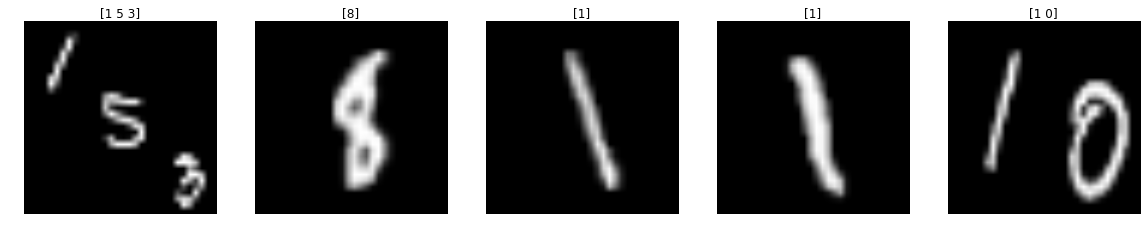

In [7]:
from PIL import Image
import os
import sys
import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams['figure.figsize'] = (20.0, 20.0)
f, ax = plt.subplots(nrows=1, ncols=5)

im_samples = []
    
for i,j in enumerate(np.sort(np.random.randint(0, train_labels.shape[0], size = 5))):
    im_samples.extend([j])
    ax[i].axis('off')
    label = train_labels[j,1:1+train_labels[j,0]]
    ax[i].set_title(label, loc='center')
    ax[i].imshow(train_dataset[j,:,:,0],cmap="gray")